# Bi-Orthogonality in Potapov modes

The modes of a system will not always be orthogonal because some of the signal leaks out of the system. 
This is demonstrated in the notebook "orthogonality testing".
In this notebook we will attempt to construct the bi-orthogonal basis, which is orthogonal. We refer the reader to https://arxiv.org/pdf/1308.2609.pdf

The example used here is example 3 in our code, which corresponds to figure 7 in our paper. This example is formed by two inter-linked cavities with two inputs and outputs.

Once we have a bi-orthogonal basis, a modified Hamiltonian can be constructed by expanding the various operators (such as the electric field) in the bi-orthogonal basis, as in http://journals.aps.org/pra/pdf/10.1103/PhysRevA.65.023803

In [1]:
import Potapov_Code.Roots as Roots 
import Potapov_Code.Potapov as Potapov
import Potapov_Code.Time_Delay_Network as Time_Delay_Network
import Potapov_Code.Time_Sims as Time_Sims
import Potapov_Code.functions as functions
import Potapov_Code.tests as tests

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%pylab inline
#plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [83]:
Ex = Time_Delay_Network.Example3(r1= 0.9,r2 = 0.4, r3 = 0.9,max_freq=50.,max_linewidth=35.)
Ex.run_Potapov(commensurate_roots=True)
E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)
Mat = functions.make_normalized_inner_product_matrix(roots,modes,delays)

In [84]:
E = Ex.E

In [85]:
M1 = Ex.M1

In [86]:
spatial_vecs = []
for i in xrange(len(roots)):
    evals,evecs = la.eig(M1*E(roots[i]))
    spatial_vecs.append(evecs[:,np.argmin(abs(1.-evals))])

In [87]:
left_spatial_vecs = []
for i in xrange(len(roots)):
    evals,evecs = la.eig(((M1*E(roots[i])).H))
    left_spatial_vecs.append(evecs[:,np.argmin(abs(1.-evals))])

In [88]:
bi_orth_mat = np.zeros((len(spatial_vecs),len(spatial_vecs)),dtype=complex)
for i,(vec1,root1) in enumerate(zip(spatial_vecs,roots)):
    for j,(vec2,root2) in enumerate(zip(left_spatial_vecs,roots)):
        s = 0
        for delay,e1,e2 in zip(delays,vec1,vec2):
            if i == j:
                s+=e1*e2.H*delay
            else:
                s += (e1*e2.H*1j*(np.exp(-1j*delay*(root1-root2).imag) - 1. )
                        /(root1-root2).imag )
        bi_orth_mat[i,j] = s[0,0]

In [89]:
def contour_plot(Mat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(abs(Mat), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

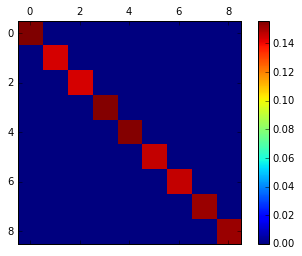

In [90]:
contour_plot(abs(bi_orth_mat))

In [66]:
def make_biorthogonal_spatial_modes(roots,M1,E):
    spatial_vecs = []
    for i in xrange(len(roots)):
        evals,evecs = la.eig(M1*E(roots[i]))
        spatial_vecs.append(evecs[:,np.argmin(abs(1.-evals))])

    left_spatial_vecs = []
    for i in xrange(len(roots)):
        evals,evecs = la.eig(((M1*E(roots[i])).H))
        left_spatial_vecs.append(evecs[:,np.argmin(abs(1.-evals))])
        
    return left_spatial_vecs,spatial_vecs

In [67]:
def make_biorthogonal_inner_product_matrix(left_spatial_vecs,spatial_vecs,roots,delays):
    bi_orth_mat = np.zeros((len(spatial_vecs),len(spatial_vecs)),dtype=complex)
    for i,(vec1,root1) in enumerate(zip(spatial_vecs,roots)):
        for j,(vec2,root2) in enumerate(zip(left_spatial_vecs,roots)):
            s = 0
            for delay,e1,e2 in zip(delays,vec1,vec2):
                if i == j:
                    s+=e1*e2.H*delay
                else:
                    s += (e1*e2.H*1j*(np.exp(-1j*delay*(root1-root2).imag) - 1. )
                            /(root1-root2).imag )
            bi_orth_mat[i,j] = s[0,0]
    return bi_orth_mat

In [91]:
def run_example3(r1=0.9,r2=0.4,r3=0.9):
    Ex = Time_Delay_Network.Example3(r1=r1,r2=r2,r3=r3,max_freq=50.,max_linewidth=35.)
    Ex.run_Potapov(commensurate_roots=True)
    E = Ex.E
    roots = Ex.roots
    M1 = Ex.M1
    delays = Ex.delays
    left_spatial_vecs,spatial_vecs = make_biorthogonal_spatial_modes(roots,M1,E)
    Mat = make_biorthogonal_inner_product_matrix(left_spatial_vecs,spatial_vecs,roots,delays)
    #contour_plot(Mat)
    return Mat

In [106]:
def off_diagonal_error(M):
    err = 0.
    if M.shape[0] != M.shape[1]:
        print "Not a square matrix!"
        return 0.
    length = M.shape[0]
    for i in range(length):
        for j in range(length):
            if i != j:
                err += abs(M[i,j])**2
    return np.sqrt(err) / (length*(length - 1))

In [92]:
rs = [.01,0.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99,.999]

## Varying r1 and r3 -- the input-output mirrors

In [93]:
Ms = {}
for r in rs:
    Ms[r] = run_example3(r1=r,r3=r)

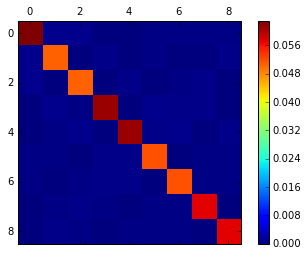

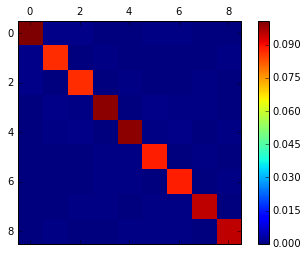

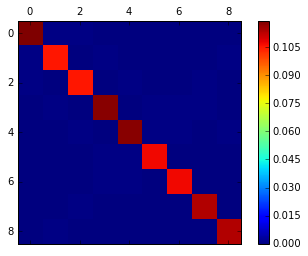

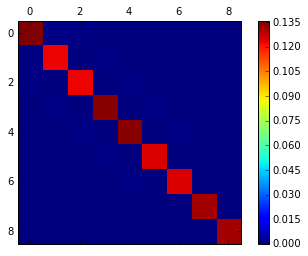

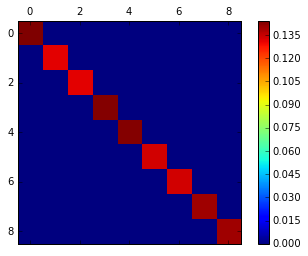

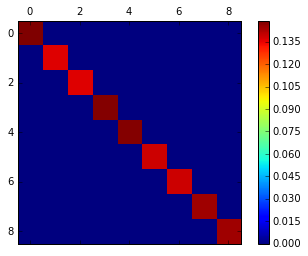

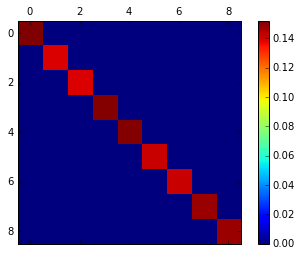

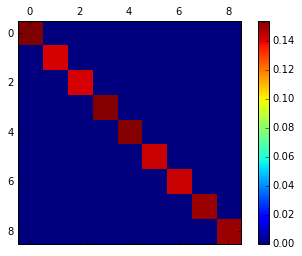

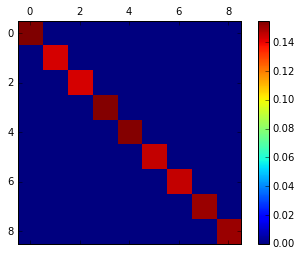

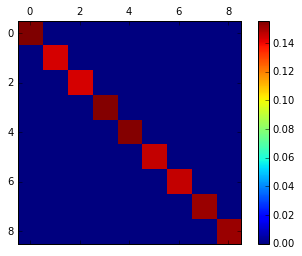

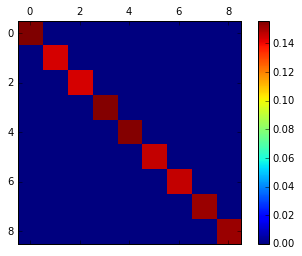

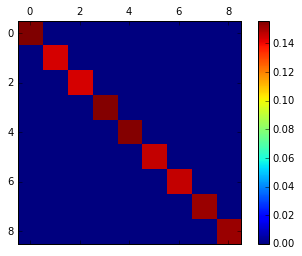

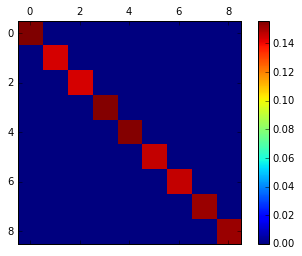

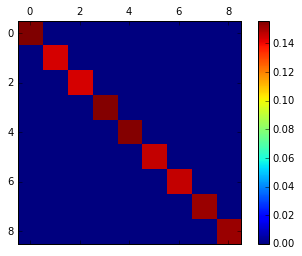

In [94]:
for r in rs:
    contour_plot(Ms[r])

In [112]:
err = {}
for r in rs:
    err[r] =  off_diagonal_error(Ms[r])

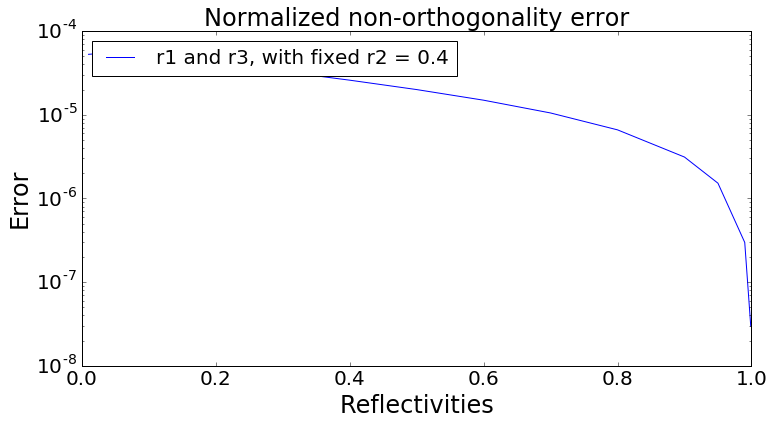

In [113]:
plt.figure(figsize = (12,6))
plt.plot(rs,[err[r] for r in rs],label='r1 and r3, with fixed r2 = 0.4')
plt.yscale('log')
plt.xlabel('Reflectivities',{'fontsize': 24})
plt.title('Normalized non-orthogonality error',{'fontsize': 24})
plt.ylabel('Error',{'fontsize': 24})
plt.yticks( size=20)
plt.xticks( size=20)
plt.legend(loc='upper left',fontsize=20)
plt.savefig('orth_err.pdf')

## Varying r1 with constant r3=1

In [97]:
Ms0 = {}
for r in rs:
    Ms0[r] = run_example3(r1=r,r3=1.)

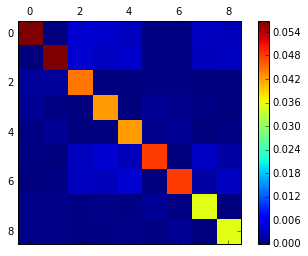

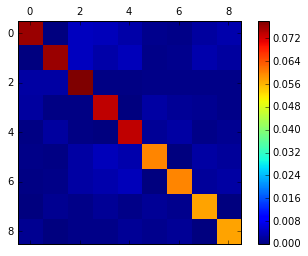

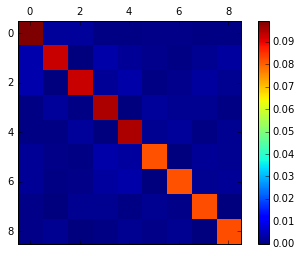

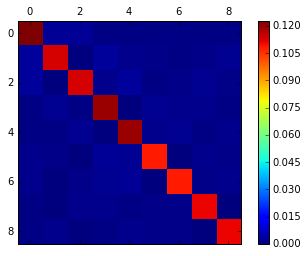

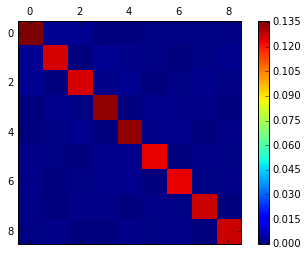

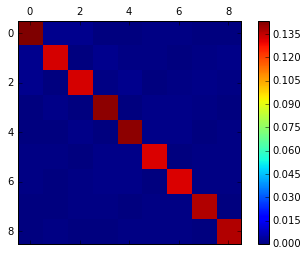

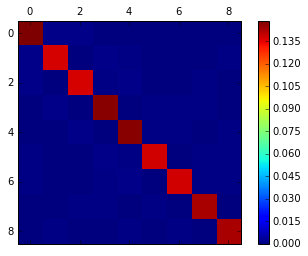

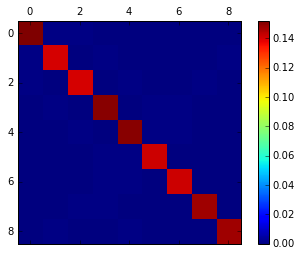

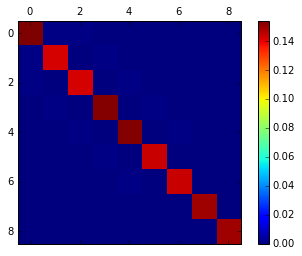

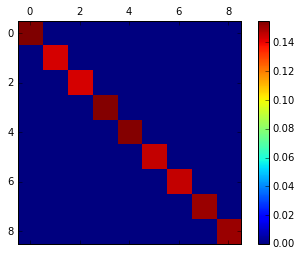

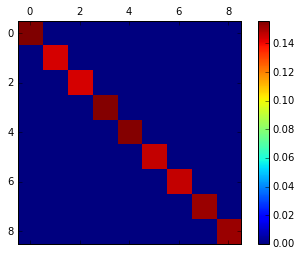

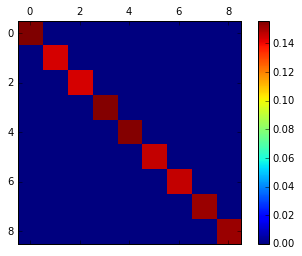

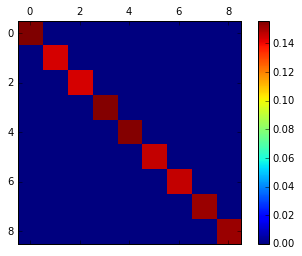

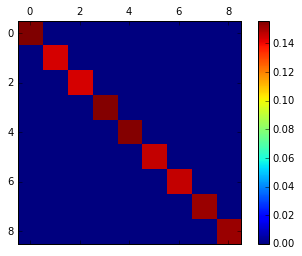

In [98]:
for r in rs:
    contour_plot(Ms0[r])

In [108]:
err0 = {}
for r in rs:
    err0[r] =  off_diagonal_error(Ms0[r])

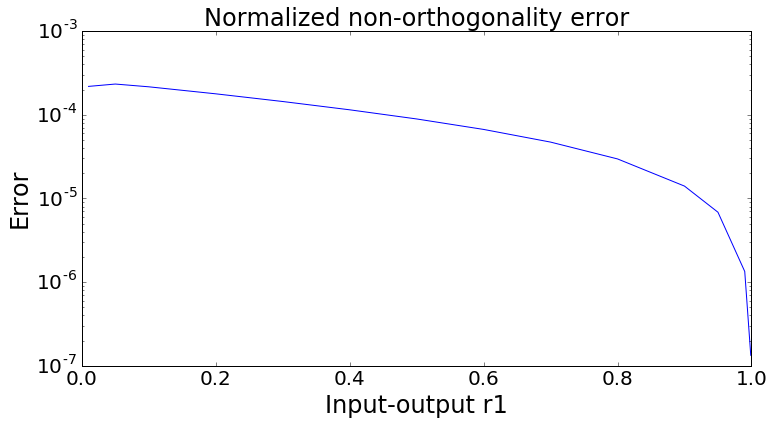

In [109]:
plt.figure(figsize = (12,6))
plt.plot(rs,[err0[r] for r in rs])
plt.yscale('log',size=32)
plt.xlabel('Input-output r1',{'fontsize': 24})
plt.title('Normalized non-orthogonality error',{'fontsize': 24})
plt.ylabel('Error',{'fontsize': 24})
plt.yticks( size=20)
plt.xticks( size=20)
plt.savefig('orth_err.pdf')

## Varying r2-- the internal mirror

In [101]:
Ms2 = {}
for r in rs:
    Ms2[r] = run_example3(r1=.9,r2 = r,r3=.9)

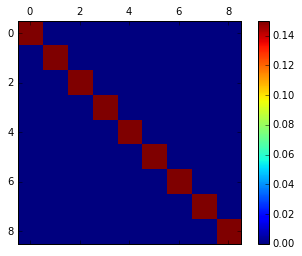

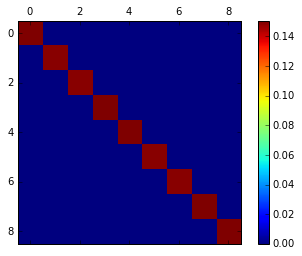

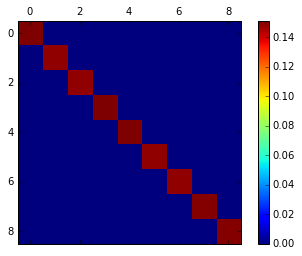

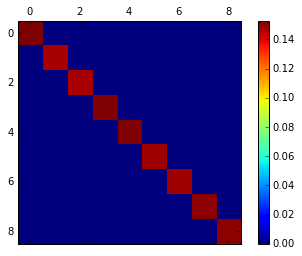

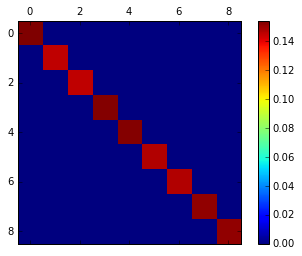

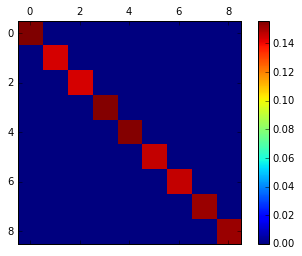

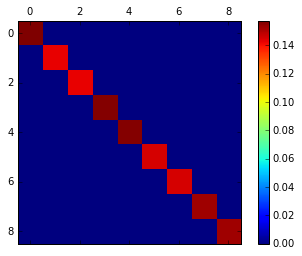

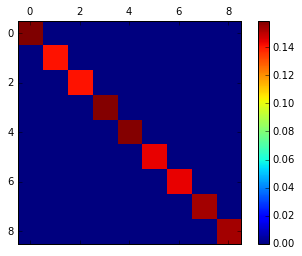

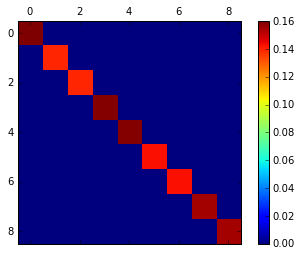

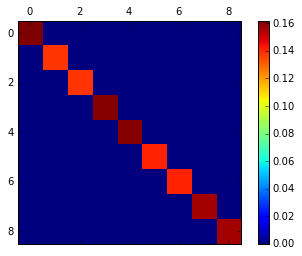

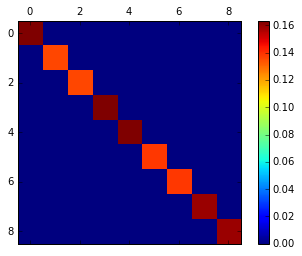

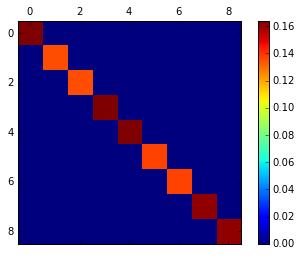

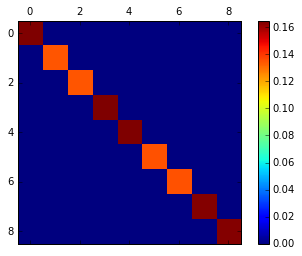

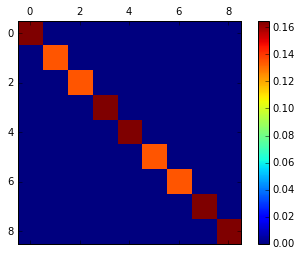

In [102]:
for r in rs:
    contour_plot(Ms2[r])

In [110]:
err2 = {}
for r in rs:
    err2[r] =  off_diagonal_error(Ms2[r])

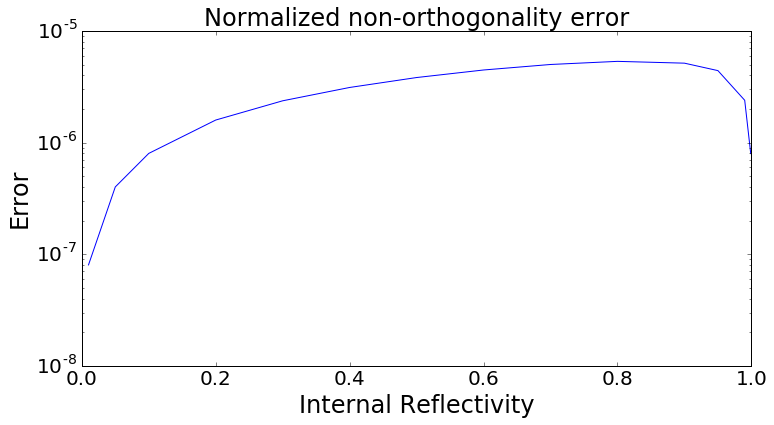

In [111]:
plt.figure(figsize = (12,6))
plt.plot(rs,[err2[r] for r in rs])
plt.yscale('log')
plt.xlabel('Internal Reflectivity',{'fontsize': 24})
plt.title('Normalized non-orthogonality error',{'fontsize': 24})
plt.ylabel('Error',{'fontsize': 24})
plt.yticks( size=20)
plt.xticks( size=20)
plt.savefig('orth_err.pdf')

# Plot all 3 together

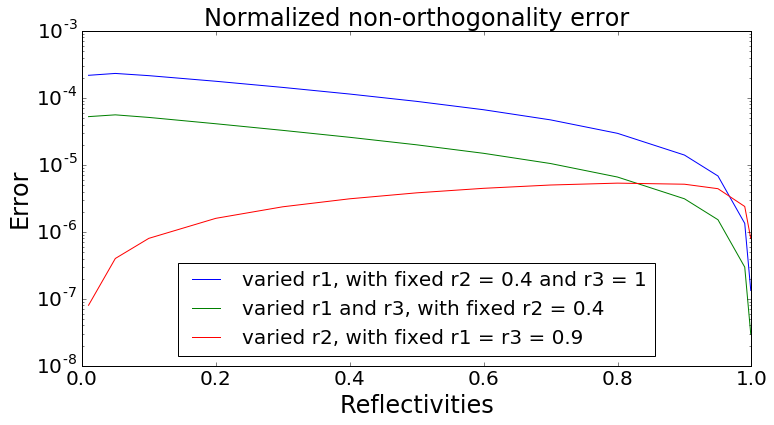

In [116]:
plt.figure(figsize = (12,6))
plt.plot(rs,[err0[r] for r in rs],label='varied r1, with fixed r2 = 0.4 and r3 = 1')
plt.plot(rs,[err[r] for r in rs],label='varied r1 and r3, with fixed r2 = 0.4')
plt.plot(rs,[err2[r] for r in rs],label='varied r2, with fixed r1 = r3 = 0.9')

plt.yscale('log')
plt.xlabel('Reflectivities',{'fontsize': 24})
plt.title('Normalized non-orthogonality error',{'fontsize': 24})
plt.ylabel('Error',{'fontsize': 24})
plt.yticks( size=20)
plt.xticks( size=20)
plt.legend(loc='lower center',fontsize=20)
plt.savefig('orth_err.pdf')